# Introduction

Import required libraries:

In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Load the data:

In [2]:
data=pd.read_csv("resp_person_27.02.csv", sep=";", dtype="str")
data.columns=["lot_id", "organiser_name", "organiser_id", "lot_status", "lot_cpv", "procur_proc", "date", "lot_sum", "lot_saving", "junk_var"]

del(data["junk_var"])
data.dropna(inplace=True)
data.set_index("lot_id", inplace=True)

# remove unsuccessful tenders
data = data[data["lot_status"]=="Завершено лот закупівлі"]

# appropriate formats
data["date"]=pd.to_datetime(data["date"], format='%d.%m.%Y')
data["lot_sum"]=data["lot_sum"].str.replace(",", ".").apply(float)
data["lot_saving"]=data["lot_saving"].str.replace(",", ".").apply(float)

Some additional variables:

In [3]:
data["lot_cpv_2"]=data["lot_cpv"].str[:2]
data["lot_cpv_4"]=data["lot_cpv"].str[:4]

Resulted DataFrame:

In [4]:
print("The shape of the dataset: ", data.shape)
data.head(3)

The shape of the dataset:  (901989, 10)


,organiser_name,organiser_id,lot_status,lot_cpv,procur_proc,date,lot_sum,lot_saving,lot_cpv_2,lot_cpv_4
lot_id,,,,,,,,,,
UA-2017-12-18-000621-b-L1,"ДОЧІРНЄ ПІДПРИЄМСТВО ""ХМЕЛЬНИЦЬКИЙ ОБЛАВТОДОР""...",31100492,Завершено лот закупівлі,09130000-9 Нафта і дистиляти,Процедура звітування про укладений договір,2017-12-18,477780.0,0.0,09,0913
UA-2017-05-13-000947-b-L1,"Державна установа ""Харківська установа виконан...",08564587,Завершено лот закупівлі,09130000-9 Нафта і дистиляти,Процедура звітування про укладений договір,2017-05-13,5600.0,0.0,09,0913
UA-2017-04-25-000168-b-L1,Відділ освіти Марганецької міської ради,02142359,Завершено лот закупівлі,09130000-9 Нафта і дистиляти,Процедура звітування про укладений договір,2017-04-25,1997.5,0.0,09,0913


# Описові дані

In [5]:
df_org=data[["organiser_id", "organiser_name"]].drop_duplicates().reset_index(drop=True).set_index("organiser_id")
df_org.shape

(26429, 1)

In [6]:
types = pd.read_csv("groups.csv", dtype="str").fillna("")
types = types[["organiser_id", "type_high"]].set_index("organiser_id")
types.columns = ["type"]

In [7]:
df_org = df_org.merge(types, left_index=True, right_index=True)
df_org.shape

(26433, 2)

## Аналіз ключових показників

**Створюємо новий масив даних, який включає такі змінн:**

**    1. Кількість проведених закупівель**

In [8]:
df_org["#_lots"] = data["organiser_id"].value_counts()

# share
df_org["#_lots_%"]=df_org["#_lots"]/sum(df_org["#_lots"])

In [9]:
lot_number = pd.DataFrame(df_org["#_lots"].describe())
lot_number["cum_sum"] = df_org["#_lots"].sort_values().cumsum().reset_index(drop=True).describe()

print("Розподіл організаторів за кількістю проведених закупівель (лотів):")
lot_number

Розподіл організаторів за кількістю проведених закупівель (лотів):


,#_lots,cum_sum
count,26433.000000,26433.000000
mean,34.128173,112710.130746
std,90.209062,161987.636426
min,1.000000,1.000000
25%,2.000000,9089.000000
50%,8.000000,39877.000000
75%,29.000000,145957.000000
max,3558.000000,902110.000000


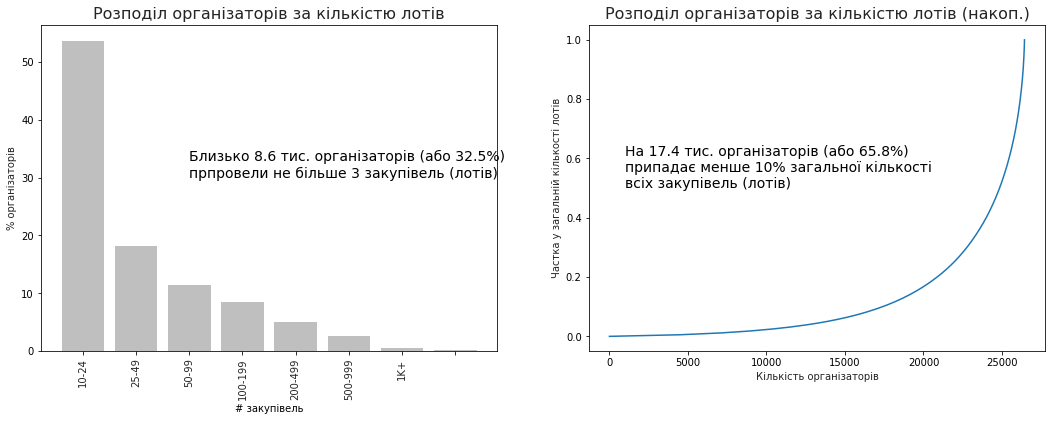

In [10]:
figure_1=plt.figure(figsize=(18, 6))

# figure 1. Distribution by # of lots
ax_1 = figure_1.add_subplot(121)

distr_tot=pd.DataFrame(pd.cut(df_org["#_lots"], 
                       [0, 10, 25, 50, 100, 200, 500, 1000, 5000],
                       right=False).value_counts(sort=False))
distr_tot.index=["0-9", "10-24", "25-49", "50-99", "100-199", "200-499", "500-999", "1K+"] 

ax_1.bar(np.arange(len(distr_tot)), list(100*distr_tot["#_lots"]/sum(distr_tot["#_lots"])),
         color="grey",
         alpha=0.5)


ax_1.set_title("Розподіл організаторів за кількістю лотів", color="#252525", fontsize = 16)
ax_1.set_ylabel('% організаторів', color="#252525")
ax_1.set_xlabel('# закупівель')
ax_1.set_xticklabels(distr_tot.index, rotation='vertical', color="#252525")
ax_1.text(2, 30, "Близько {} тис. організаторів (або {}%) \nпрпровели не більше 3 закупівель (лотів)"
          .format(round(len(df_org[df_org["#_lots"]<=3])/1000, 1),
                  round(len(df_org[df_org["#_lots"]<=3])/len(df_org["#_lots"])*100, 1)), 
          fontsize = 14)
# figure 2
ax_2 = figure_1.add_subplot(122)

cumsum=pd.DataFrame(df_org["#_lots_%"].sort_values().cumsum()).reset_index(drop=True)
cumsum.columns = ["number"]

plt.plot(cumsum["number"].reset_index(drop=True))

plt.title("Розподіл організаторів за кількістю лотів (накоп.)", color="#252525", fontsize = 16)
plt.xlabel('Кількість організаторів', color="#252525")
plt.ylabel('Частка у загальній кількості лотів', color="#252525")

ax_2.text(1000, 0.5, "На {} тис. організаторів (або {}%) \nприпадає менше 10% загальної кількості \nвсіх закупівель (лотів)"
          .format(round(len(cumsum[cumsum["number"]<=0.1])/1000, 1),
                  round(len(cumsum[cumsum["number"]<=0.1])/len(cumsum["number"])*100, 1)),
          fontsize = 14)

plt.show()

**УВАГА!!!!!**

Викидаємо організаторів, які провели не більше трьох закупівель протягом 2017 року:

In [11]:
df_org_reserve = df_org.copy()
df_org = df_org[df_org["#_lots"]>3]

data_reserve = data.copy()
data = data[data["organiser_id"].isin(list(df_org.index))]

**    2. Частка звітів**

In [12]:
df_org["%_lots_reports"] = ((data["procur_proc"][data["procur_proc"]=="Процедура звітування про укладений договір"]
                            .groupby(data["organiser_id"]).count()) / df_org["#_lots"]).fillna(0)

In [13]:
distr_reports=pd.DataFrame(pd.cut(df_org["%_lots_reports"], 
                           np.arange(0,1.2,0.1),
                           right=False).value_counts(sort=False))

index=[str(el) for el in distr_reports.index[:-1]]; index.append("1")
distr_reports.index = index

print("Розподіл організаторів за часткою звітів:")
distr_reports

Розподіл організаторів за часткою звітів:


,%_lots_reports
"[0.0, 0.1)",2688
"[0.1, 0.2)",796
"[0.2, 0.3)",981
"[0.3, 0.4)",650
"[0.4, 0.5)",773
"[0.5, 0.6)",1318
"[0.6, 0.7)",917
"[0.7, 0.8)",1433
"[0.8, 0.9)",2249
"[0.9, 1.0)",2346


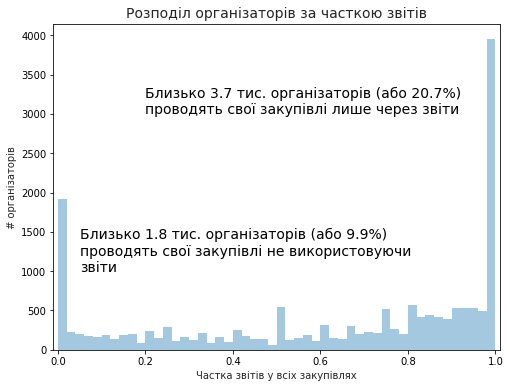

In [14]:
figure_2=plt.figure(figsize=(8, 6))
# figure 2
ax_1 = figure_2.add_subplot(111)

#ax_1.bar(np.arange(len(distr_reports)), list(100*distr_reports["%_lots_reports"]/sum(distr_reports["%_lots_reports"])))
sns.distplot(df_org["%_lots_reports"], hist=True, kde=False, bins=50)

ax_1.set_xlim([-0.01, 1.01])
ax_1.set_title("Розподіл організаторів за часткою звітів", color="#252525", fontsize = 14)
ax_1.set_ylabel('# організаторів', color="#252525")
ax_1.set_xlabel('Частка звітів у всіх закупівлях', color="#252525")

ax_1.text(0.05, 1000, "Близько {} тис. організаторів (або {}%) \nпроводять свої закупівлі не використовуючи \nзвіти"
          .format(round(len(df_org[df_org["%_lots_reports"]==0])/1000, 1),
                  round(len(df_org[df_org["%_lots_reports"]==0])/len(df_org["#_lots"])*100, 1)), 
          fontsize = 14)
ax_1.text(0.2, 3000, "Близько {} тис. організаторів (або {}%) \nпроводять свої закупівлі лише через звіти"
          .format(round(len(df_org[df_org["%_lots_reports"]==1])/1000, 1),
                  round(len(df_org[df_org["%_lots_reports"]==1])/len(df_org["#_lots"])*100, 1)), 
          fontsize = 14)

plt.show()

In [15]:
# len(df_org[((df_org["%_lots_reports"]==0) | (df_org["%_lots_reports"]==1))])/len(df_org)
# df_org[(df_org["%_lots_reports"]==0)]["#_lots"].value_counts()

**    3. Загальна сума закупівель**

In [16]:
df_org["$_lots"] = data["lot_sum"].groupby(data["organiser_id"]).sum()

# share
df_org["$_lots_%"]=df_org["$_lots"]/sum(df_org["$_lots"])

In [17]:
distr_tot_sum=pd.DataFrame(pd.cut(df_org["$_lots"], 
                       [0, 50000, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000, 5000000000000000],
                       right=False).value_counts(sort=False))
distr_tot_sum.index=["0-49", "50-99", "100-199", "200-499", "500-999", "1000-1999", "2000-4999", "5000-9999", "10000+"] 

print("Розподіл організаторів за загальною сумою проведених закупівель:")
distr_tot_sum

Розподіл організаторів за загальною сумою проведених закупівель:


,$_lots
0-49,180
50-99,270
100-199,528
200-499,1614
500-999,2312
1000-1999,3064
2000-4999,3913
5000-9999,2264
10000+,3691


In [18]:
sum(distr_tot_sum.iloc[:5, 0])/sum(distr_tot_sum.iloc[:, 0])

0.27494954025566271

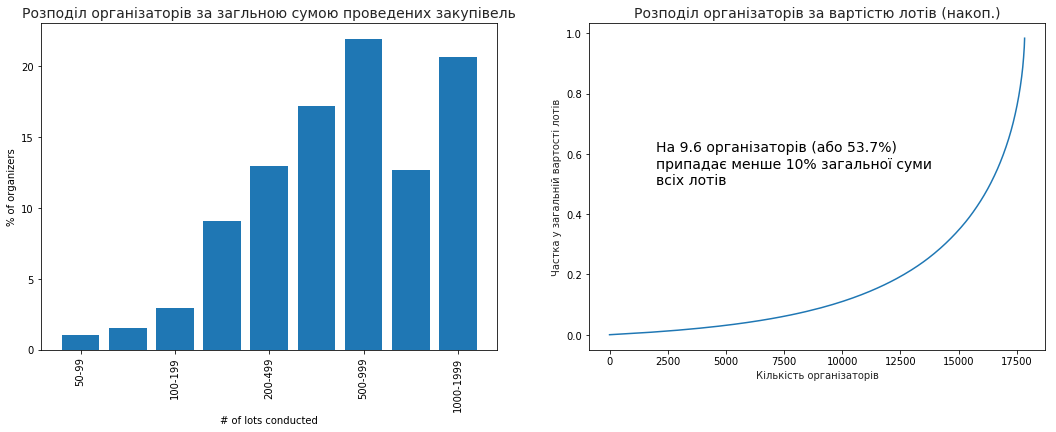

In [19]:
figure_3=plt.figure(figsize=(18, 6))

# figure 1. Distribution by value of lots
ax_1 = figure_3.add_subplot(121)

ax_1.bar(np.arange(len(distr_tot_sum)), list(100*distr_tot_sum["$_lots"]/sum(distr_tot_sum["$_lots"])))

ax_1.set_title("Розподіл організаторів за загльною сумою проведених закупівель", color="#252525", fontsize = 14)
ax_1.set_ylabel('% of organizers')
ax_1.set_xlabel('# of lots conducted')
ax_1.set_xticklabels(distr_tot_sum.index, rotation='vertical')

# figure 2
ax_2 = figure_3.add_subplot(122)

cumsum=pd.DataFrame(df_org["#_lots_%"].sort_values().cumsum()).reset_index(drop=True)
cumsum.columns = ["value"]

plt.plot(cumsum["value"].reset_index(drop=True))

plt.title("Розподіл організаторів за вартістю лотів (накоп.)", color="#252525", fontsize = 14)
plt.xlabel('Кількість організаторів', color="#252525")
plt.ylabel('Частка у загальній вартості лотів', color="#252525")
ax_2.text(2000, 0.5, "На {} організаторів (або {}%) \nприпадає менше 10% загальної суми \nвсіх лотів"
          .format(round(len(cumsum[cumsum["value"]<=0.1])/1000, 1),
                  round(len(cumsum[cumsum["value"]<=0.1])/len(cumsum["value"])*100, 1)), 
          fontsize = 14)



plt.show()

**    4. Однорідність сум закупівель**

In [20]:
df_org["$_lots_hh"]=data["lot_sum"].groupby(data["organiser_id"]).apply(lambda x: sum((x/sum(x))*(x/sum(x))))

In [21]:
distr_sum_hh=pd.DataFrame(pd.cut(df_org["$_lots_hh"], 
                           np.arange(0,1.2,0.1),
                           right=False).value_counts(sort=False))

index=[str(el) for el in distr_reports.index[:-1]]; index.append("1")
distr_sum_hh.index = index

print("Розподіл організаторів за часткою звітів:")
distr_sum_hh

Розподіл організаторів за часткою звітів:


,$_lots_hh
"[0.0, 0.1)",4865
"[0.1, 0.2)",5396
"[0.2, 0.3)",3739
"[0.3, 0.4)",1805
"[0.4, 0.5)",941
"[0.5, 0.6)",471
"[0.6, 0.7)",251
"[0.7, 0.8)",193
"[0.8, 0.9)",122
"[0.9, 1.0)",53


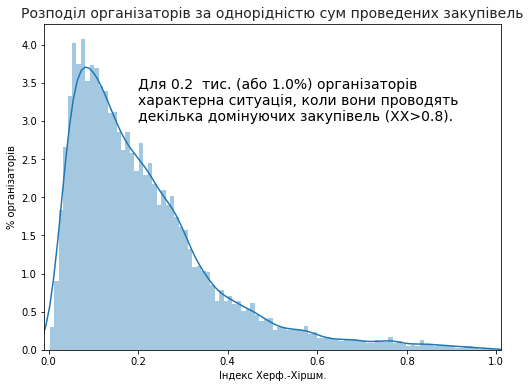

In [22]:
figure_4=plt.figure(figsize=(18, 6))

# figure 1. Distribution by value of lots
ax_1 = figure_4.add_subplot(121)

#ax_1.bar(np.arange(len(distr_tot_sum)), list(100*distr_tot_sum["$_lots"]/sum(distr_tot_sum["$_lots"])))
sns.distplot(df_org["$_lots_hh"], hist=True, bins=100)

ax_1.set_xlim([-0.01, 1.01])
ax_1.set_title("Розподіл організаторів за однорідністю сум проведених закупівель", color="#252525", fontsize = 14)
ax_1.set_ylabel('% організаторів')
ax_1.set_xlabel('Індекс Херф.-Хіршм.')
ax_1.text(0.2, 3, "Для {}  тис. (або {}%) організаторів \nхарактерна ситуація, коли вони проводять \nдекілька домінуючих закупівель (ХХ>0.8)."
          .format(round(len(df_org[df_org["$_lots_hh"]>0.8])/1000, 1),
                  round(len(df_org[df_org["$_lots_hh"]>0.8])/len(df_org["$_lots_hh"])*100, 1)), 
          fontsize = 14)

plt.show()

**    5. Кількість різних кодів CPV на 4-му знаку та їх різноманітність (Херфіндаль - Хіршман)**

In [23]:
# number of different cpv
df_org["#_cpv"]=data["lot_cpv_4"].groupby(data["organiser_id"]).nunique()

In [24]:
# load cpv - homo
homo_cpv = pd.read_excel("homo_cpv.xlsx")
homo_cpv = list(homo_cpv["homo_cpv"].str[:4].drop_duplicates())

df_org["cpv_homo"]=(data["lot_cpv_4"][data["lot_cpv_4"].isin(homo_cpv)].groupby(data["organiser_id"]).nunique())
df_org.fillna(0, inplace=True)
df_org["cpv_homo_%"] = df_org["cpv_homo"]/df_org["#_cpv"]

In [25]:
print ("Розподіл організаторів за кількістю унікальних CPV та їхнім домінуванням:")
pd.concat([pd.DataFrame(df_org["#_cpv"].describe()), pd.DataFrame(df_org["cpv_homo_%"].describe())], axis=1)

Розподіл організаторів за кількістю унікальних CPV та їхнім домінуванням:


,#_cpv,cpv_homo_%
count,17836.000000,17836.000000
mean,18.672516,0.123436
std,23.965441,0.162885
min,1.000000,0.000000
25%,5.000000,0.000000
50%,10.000000,0.071429
75%,23.000000,0.189189
max,362.000000,1.000000


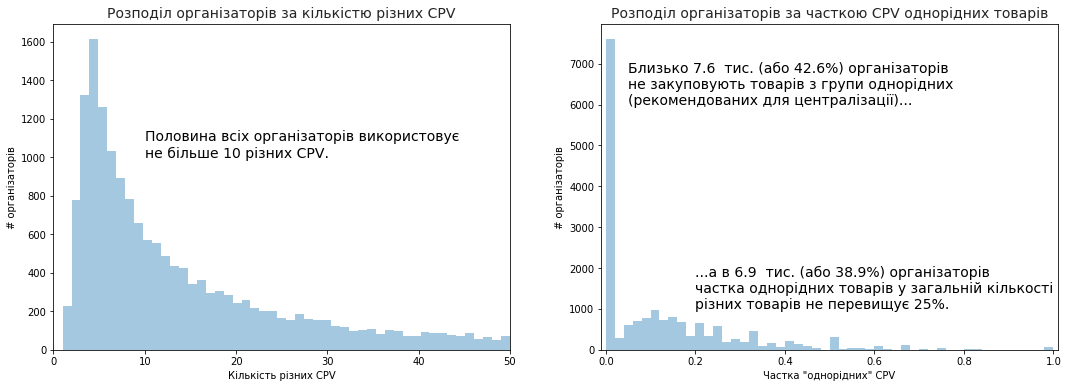

In [26]:
figure_6=plt.figure(figsize=(18, 6))

# figure 1. 
ax_1 = figure_6.add_subplot(121)

sns.distplot(df_org["#_cpv"][df_org["#_cpv"]<=50], hist=True, kde=False, bins=50)

ax_1.set_xlim([0, 50])
ax_1.set_title("Розподіл організаторів за кількістю різних CPV", color="#252525", fontsize = 14)
ax_1.set_ylabel('# організаторів')
ax_1.set_xlabel('Кількість різних CPV')
ax_1.text(10, 1000, "Половина всіх організаторів використовує \nне більше {} різних CPV."
          .format(int(df_org["#_cpv"].describe()["50%"])), 
          fontsize = 14)

# figure 2. 
ax_2 = figure_6.add_subplot(122)

sns.distplot(df_org["cpv_homo_%"], hist=True, kde=False)

ax_2.set_xlim([-0.01, 1.01])
ax_2.set_title("Розподіл організаторів за часткою CPV однорідних товарів", color="#252525", fontsize = 14)
ax_2.set_ylabel('# організаторів')
ax_2.set_xlabel('Частка "однорідних" CPV')
ax_2.text(0.05, 6000, "Близько {}  тис. (або {}%) організаторів \nне закуповують товарів з групи однорідних \n(рекомендованих для централізації)..."
          .format(round(len(df_org[(df_org["cpv_homo_%"]==0) ])/1000, 1),
                  round(len(df_org[(df_org["cpv_homo_%"]==0) ])/len(df_org["cpv_homo_%"])*100, 1)), 
          fontsize = 14)

ax_2.text(0.2, 1000, "...а в {}  тис. (або {}%) організаторів \nчастка однорідних товарів у загальній кількості \nрізних товарів не перевищує 25%."
          .format(round(len(df_org[(df_org["cpv_homo_%"]>0) & (df_org["cpv_homo_%"]<0.25)])/1000, 1),
                  round(len(df_org[(df_org["cpv_homo_%"]>0) & (df_org["cpv_homo_%"]<0.25) ])/len(df_org["cpv_homo_%"])*100, 1)), 
          fontsize = 14)


plt.show()

## Загальна характеристика масиву даних

**Масив даних:**

In [27]:
df_org.head(3)

,organiser_name,type,#_lots,#_lots_%,%_lots_reports,$_lots,$_lots_%,$_lots_hh,#_cpv,cpv_homo,cpv_homo_%
organiser_id,,,,,,,,,,,
00010300,Державна служба експортного контролю України,,23,0.000025,0.956522,626677.82,0.000001,0.089680,13,6.0,0.461538
00012925,Міністерство охорони здоров'я України,,48,0.000053,0.500000,57096494.57,0.000117,0.076429,29,11.0,0.379310
00013238,Громадська організація «Національний олімпійсь...,,31,0.000034,0.419355,24109869.00,0.000049,0.075545,17,1.0,0.058824


**Описова статистика:**

In [28]:
df_org.describe()

,#_lots,#_lots_%,%_lots_reports,$_lots,$_lots_%,$_lots_hh,#_cpv,cpv_homo,cpv_homo_%
count,17836.000000,17836.000000,17836.000000,1.783600e+04,1.783600e+04,17836.000000,17836.000000,17836.000000,17836.000000
mean,49.744169,0.000055,0.625766,2.746935e+07,5.606638e-05,0.211288,18.672516,2.505102,0.123436
std,106.349178,0.000118,0.359728,4.682832e+08,9.557905e-04,0.161540,23.965441,3.844733,0.162885
min,4.000000,0.000004,0.000000,2.500000e+03,5.102631e-09,0.002271,1.000000,0.000000,0.000000
25%,8.000000,0.000009,0.300000,8.895020e+05,1.815520e-06,0.094127,5.000000,0.000000,0.000000
50%,18.000000,0.000020,0.750000,2.442427e+06,4.985122e-06,0.171096,10.000000,1.000000,0.071429
75%,49.000000,0.000054,0.958904,7.710258e+06,1.573704e-05,0.279359,23.000000,3.000000,0.189189
max,3558.000000,0.003944,1.000000,5.222674e+10,1.065975e-01,0.997955,362.000000,31.000000,1.000000


**Scatter matrix:**

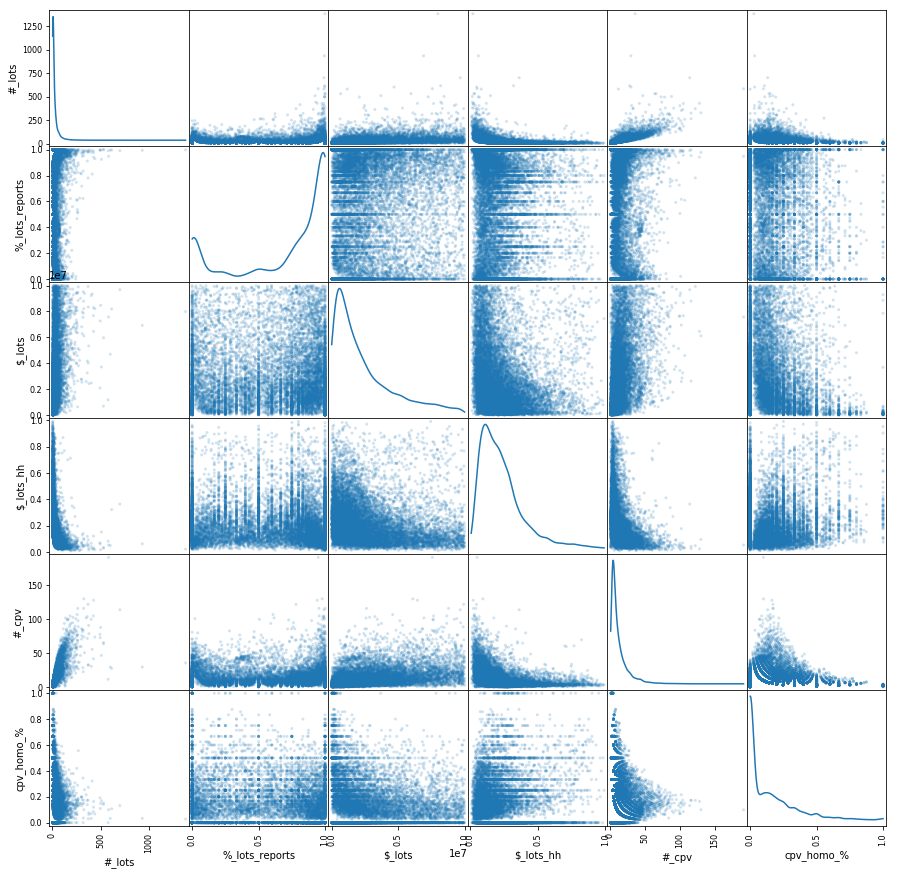

In [29]:
df_org_scatter = df_org[['organiser_name', '#_lots', '%_lots_reports', '$_lots','$_lots_hh', '#_cpv', 'cpv_homo_%']]

############!!!!!!!!!!!!!!!!!!
df_org_scatter = df_org_scatter[df_org_scatter["$_lots"]<=10000000]
fig=scatter_matrix(df_org_scatter, alpha=0.2, figsize=(15, 15), diagonal='kde')

**Heat map**

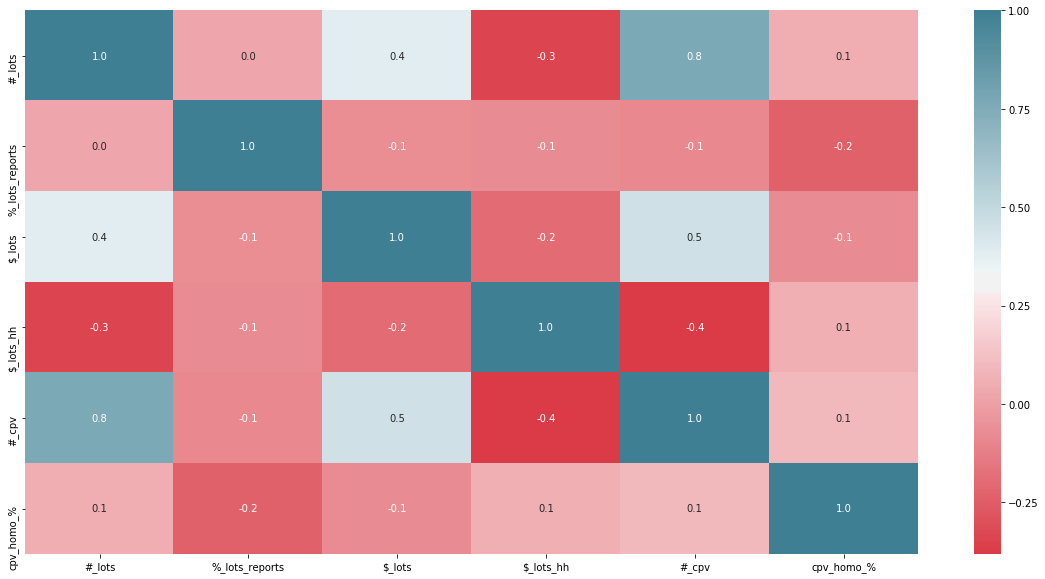

In [30]:
figure_8=plt.figure(figsize=(20, 10))

# figure 1. 
ax_1 = figure_8.add_subplot(111)

sns.heatmap(df_org_scatter.corr(), annot=True, fmt=".1f", cmap=sns.diverging_palette(10, 220, as_cmap=True))

plt.show()

# Типові характеристики підгруп

In [31]:
df_org["type"].drop_duplicates()

organiser_id
00010300                 
00015332             COMP
00022450    АДМІНІСТРАЦІЯ
00129314             EDUC
00184307            COUNC
00184945           HEALTH
Name: type, dtype: object

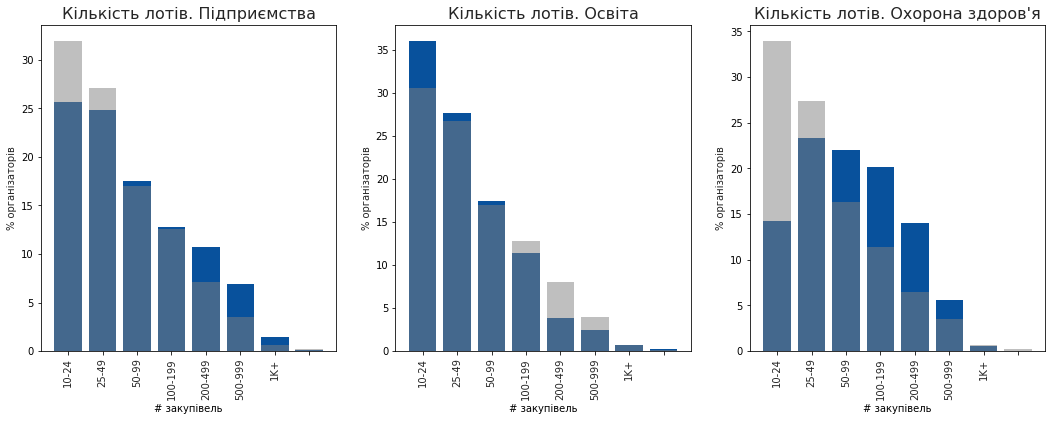

In [32]:
figure_1=plt.figure(figsize=(18, 6))

# figure 1. Distribution by # of lots
ax_1 = figure_1.add_subplot(131)

distr_tot=pd.DataFrame(pd.cut(df_org["#_lots"][df_org["type"]!="COMP"], 
                       [0, 10, 25, 50, 100, 200, 500, 1000, 5000],
                       right=False).value_counts(sort=False))
distr_tot.index=["0-9", "10-24", "25-49", "50-99", "100-199", "200-499", "500-999", "1K+"] 

distr_tot_comp=pd.DataFrame(pd.cut(df_org["#_lots"][df_org["type"]=="COMP"], 
                            [0, 10, 25, 50, 100, 200, 500, 1000, 5000],
                            right=False).value_counts(sort=False))
distr_tot_comp.index=["0-9", "10-24", "25-49", "50-99", "100-199", "200-499", "500-999", "1K+"] 

ax_1.bar(np.arange(len(distr_tot))+1, list(100*distr_tot_comp["#_lots"]/sum(distr_tot_comp["#_lots"])), 
         color="#08519c")
ax_1.bar(np.arange(len(distr_tot))+1, list(100*distr_tot["#_lots"]/sum(distr_tot["#_lots"])),
         color="grey",
         alpha=0.5)


ax_1.set_title("Кількість лотів. Підприємства", color="#252525", fontsize = 16)
ax_1.set_ylabel('% організаторів', color="#252525")
ax_1.set_xlabel('# закупівель')
ax_1.set_xticklabels(distr_tot.index, rotation='vertical', color="#252525")

# figure 2
ax_2 = figure_1.add_subplot(132)

distr_tot=pd.DataFrame(pd.cut(df_org["#_lots"][df_org["type"]!="EDUC"], 
                       [0, 10, 25, 50, 100, 200, 500, 1000, 5000],
                       right=False).value_counts(sort=False))
distr_tot.index=["0-9", "10-24", "25-49", "50-99", "100-199", "200-499", "500-999", "1K+"] 

distr_tot_comp=pd.DataFrame(pd.cut(df_org["#_lots"][df_org["type"]=="EDUC"], 
                            [0, 10, 25, 50, 100, 200, 500, 1000, 5000],
                            right=False).value_counts(sort=False))
distr_tot_comp.index=["0-9", "10-24", "25-49", "50-99", "100-199", "200-499", "500-999", "1K+"] 

ax_2.bar(np.arange(len(distr_tot))+1, list(100*distr_tot_comp["#_lots"]/sum(distr_tot_comp["#_lots"])), 
         color="#08519c")
ax_2.bar(np.arange(len(distr_tot))+1, list(100*distr_tot["#_lots"]/sum(distr_tot["#_lots"])),
         color="grey",
         alpha=0.5)


ax_2.set_title("Кількість лотів. Освіта", color="#252525", fontsize = 16)
ax_2.set_ylabel('% організаторів', color="#252525")
ax_2.set_xlabel('# закупівель')
ax_2.set_xticklabels(distr_tot.index, rotation='vertical', color="#252525")


# figure 3
ax_3 = figure_1.add_subplot(133)

distr_tot=pd.DataFrame(pd.cut(df_org["#_lots"][df_org["type"]!="HEALTH"], 
                       [0, 10, 25, 50, 100, 200, 500, 1000, 5000],
                       right=False).value_counts(sort=False))
distr_tot.index=["0-9", "10-24", "25-49", "50-99", "100-199", "200-499", "500-999", "1K+"] 

distr_tot_comp=pd.DataFrame(pd.cut(df_org["#_lots"][df_org["type"]=="HEALTH"], 
                            [0, 10, 25, 50, 100, 200, 500, 1000, 5000],
                            right=False).value_counts(sort=False))
distr_tot_comp.index=["0-9", "10-24", "25-49", "50-99", "100-199", "200-499", "500-999", "1K+"] 

ax_3.bar(np.arange(len(distr_tot))+1, list(100*distr_tot_comp["#_lots"]/sum(distr_tot_comp["#_lots"])), 
         color="#08519c")
ax_3.bar(np.arange(len(distr_tot))+1, list(100*distr_tot["#_lots"]/sum(distr_tot["#_lots"])),
         color="grey",
         alpha=0.5)


ax_3.set_title("Кількість лотів. Охорона здоров'я", color="#252525", fontsize = 16)
ax_3.set_ylabel('% організаторів', color="#252525")
ax_3.set_xlabel('# закупівель')
ax_3.set_xticklabels(distr_tot.index, rotation='vertical', color="#252525")

plt.show()

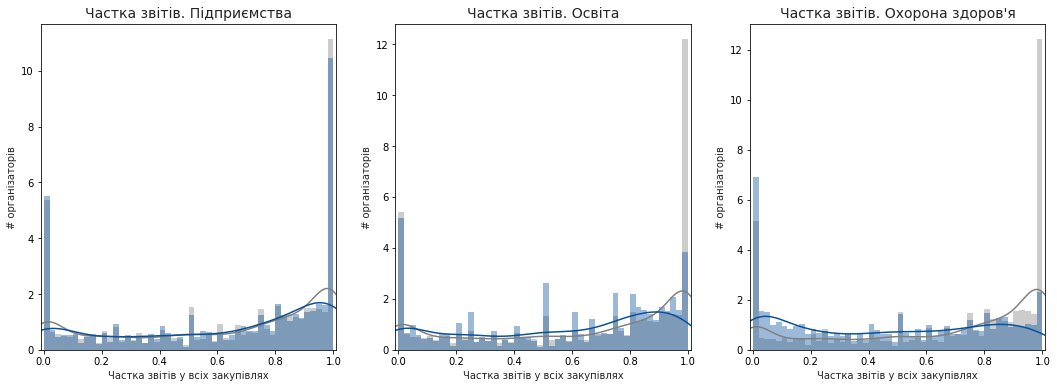

In [33]:
figure_2=plt.figure(figsize=(18, 6))
# figure 1
ax_1 = figure_2.add_subplot(131)

#ax_1.bar(np.arange(len(distr_reports)), list(100*distr_reports["%_lots_reports"]/sum(distr_reports["%_lots_reports"])))
sns.distplot(df_org["%_lots_reports"][df_org["type"]!="COMP"], hist=True, kde=True, bins=50, color="grey")
sns.distplot(df_org["%_lots_reports"][df_org["type"]=="COMP"], hist=True, kde=True, bins=50, color="#08519c")

ax_1.set_xlim([-0.01, 1.01])
ax_1.set_title("Частка звітів. Підприємства", color="#252525", fontsize = 14)
ax_1.set_ylabel('# організаторів', color="#252525")
ax_1.set_xlabel('Частка звітів у всіх закупівлях', color="#252525")

# figure 2
ax_2 = figure_2.add_subplot(132)

#ax_1.bar(np.arange(len(distr_reports)), list(100*distr_reports["%_lots_reports"]/sum(distr_reports["%_lots_reports"])))
sns.distplot(df_org["%_lots_reports"][df_org["type"]!="EDUC"], hist=True, kde=True, bins=50, color="grey")
sns.distplot(df_org["%_lots_reports"][df_org["type"]=="EDUC"], hist=True, kde=True, bins=50, color="#08519c")

ax_2.set_xlim([-0.01, 1.01])
ax_2.set_title("Частка звітів. Освіта", color="#252525", fontsize = 14)
ax_2.set_ylabel('# організаторів', color="#252525")
ax_2.set_xlabel('Частка звітів у всіх закупівлях', color="#252525")


# figure 3
ax_3 = figure_2.add_subplot(133)

#ax_1.bar(np.arange(len(distr_reports)), list(100*distr_reports["%_lots_reports"]/sum(distr_reports["%_lots_reports"])))
sns.distplot(df_org["%_lots_reports"][df_org["type"]!="HEALTH"], hist=True, kde=True, bins=50, color="grey")
sns.distplot(df_org["%_lots_reports"][df_org["type"]=="HEALTH"], hist=True, kde=True, bins=50, color="#08519c")

ax_3.set_xlim([-0.01, 1.01])
ax_3.set_title("Частка звітів. Охорона здоров'я", color="#252525", fontsize = 14)
ax_3.set_ylabel('# організаторів', color="#252525")
ax_3.set_xlabel('Частка звітів у всіх закупівлях', color="#252525")


plt.show()

# ML part

## Rescaling

Перед поділом всієї сукупності закупівельників на окремі групи (кластери), необхідно провести "рескейлінг" змінних (приведення значень до однієї шкали).

In [53]:
from sklearn import preprocessing
from pandas.plotting import scatter_matrix

In [35]:
df_org.head(3)

,organiser_name,type,#_lots,#_lots_%,%_lots_reports,$_lots,$_lots_%,$_lots_hh,#_cpv,cpv_homo,cpv_homo_%
organiser_id,,,,,,,,,,,
00010300,Державна служба експортного контролю України,,23,0.000025,0.956522,626677.82,0.000001,0.089680,13,6.0,0.461538
00012925,Міністерство охорони здоров'я України,,48,0.000053,0.500000,57096494.57,0.000117,0.076429,29,11.0,0.379310
00013238,Громадська організація «Національний олімпійсь...,,31,0.000034,0.419355,24109869.00,0.000049,0.075545,17,1.0,0.058824


In [36]:
df_org_prep=pd.DataFrame(np.log(df_org["#_lots"]))
df_org_prep["%_lots_reports"]=df_org["%_lots_reports"]

df_org_prep["$_lots"]=np.log(df_org["$_lots"])
df_org_prep["$_lots_hh"]=df_org["$_lots_hh"]

df_org_prep["#_cpv"]=df_org["#_cpv"]
df_org_prep["cpv_homo_%"]=df_org["cpv_homo_%"]

df_org_prep.head(3)

,#_lots,%_lots_reports,$_lots,$_lots_hh,#_cpv,cpv_homo_%
organiser_id,,,,,,
00010300,3.135494,0.956522,13.348188,0.089680,13,0.461538
00012925,3.871201,0.500000,17.860253,0.076429,29,0.379310
00013238,3.433987,0.419355,16.998132,0.075545,17,0.058824


In [37]:
df_org_prep.describe()

,#_lots,%_lots_reports,$_lots,$_lots_hh,#_cpv,cpv_homo_%
count,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000
mean,3.051392,0.625766,14.819758,0.211288,18.672516,0.123436
std,1.211872,0.359728,1.749464,0.161540,23.965441,0.162885
min,1.386294,0.000000,7.824046,0.002271,1.000000,0.000000
25%,2.079442,0.300000,13.698417,0.094127,5.000000,0.000000
50%,2.890372,0.750000,14.708503,0.171096,10.000000,0.071429
75%,3.891820,0.958904,15.858062,0.279359,23.000000,0.189189
max,8.176954,1.000000,24.678860,0.997955,362.000000,1.000000


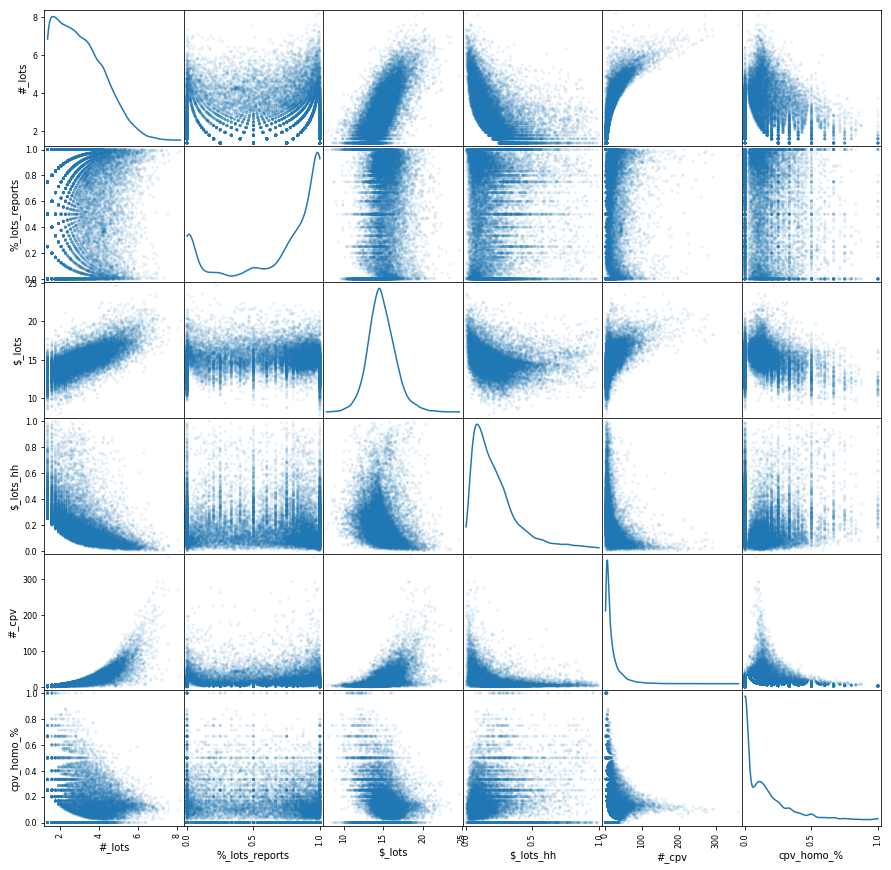

In [55]:
sc_mat=scatter_matrix(df_org_prep, alpha=0.1, figsize=(15, 15), diagonal='kde')

Scaled:

In [39]:
df_org_scaled = pd.DataFrame(preprocessing.scale(df_org_prep), columns=df_org_prep.columns, index=df_org_prep.index)
sc_mat=scatter_matrix(df_org_scaled, alpha=0.1, figsize=(15, 15), diagonal='kde')

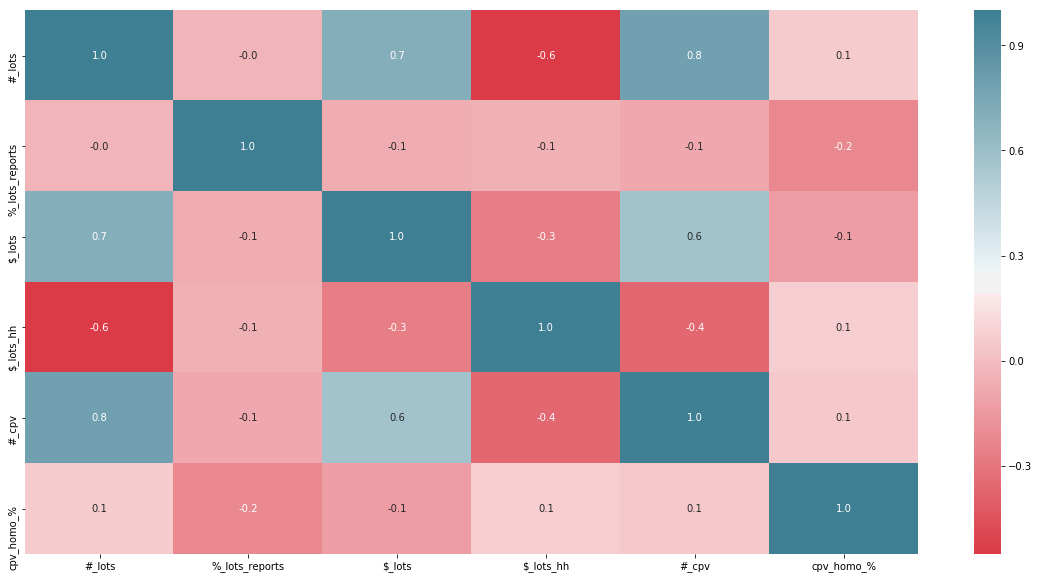

In [318]:
figure_8=plt.figure(figsize=(20, 10))

# figure 1. 
ax_1 = figure_8.add_subplot(111)

sns.heatmap(df_org_scaled[df_org_scaled.columns[:6]].corr(), annot=True, fmt=".1f", cmap=sns.diverging_palette(10, 220, as_cmap=True))

plt.show()

In [41]:
df_org_scaled.head(3)

,#_lots,%_lots_reports,$_lots,$_lots_hh,#_cpv,cpv_homo_%
organiser_id,,,,,,
00010300,0.069400,0.919486,-0.841178,-0.752821,-0.236702,2.075772
00012925,0.676500,-0.349626,1.738007,-0.834850,0.430944,1.570935
00013238,0.315715,-0.573816,1.245201,-0.840325,-0.069791,-0.396684


## Clusters

In [ ]:
from sklearn.cluster import KMeans

Властивістю вибраного методу кластеризації є визначення кількості класетрів заздалегіть. На графіках нище відображено розподіл суми похибок залежно віж кількості кластерів.  

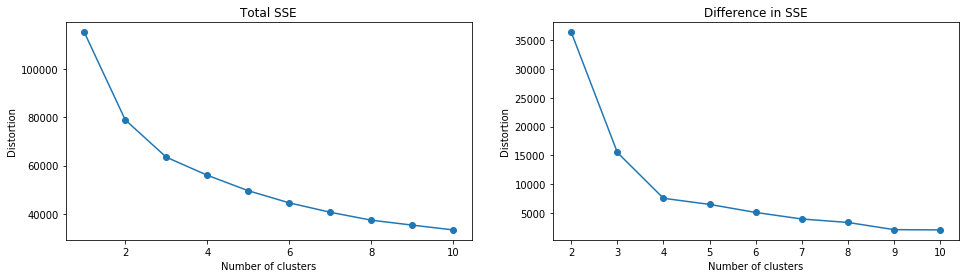

In [68]:
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_org_scaled.values)
    distortions.append(kmeans.inertia_)

figure_1=plt.figure(figsize=(16, 4))

# figure 1. Distribution by # of lots
ax_1 = figure_1.add_subplot(121)

plt.plot(range(1, 11), distortions, 
         marker="o")
plt.title("Total SSE")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")

# figure 1. Distribution by # of lots
ax_2 = figure_1.add_subplot(122)

plt.plot(range(2, 11), [distortions[i]-distortions[i+1] for i in range(len(distortions)-1)], 
         marker="o")
plt.title("Difference in SSE")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")

plt.show()

З огляду на результати, зображені на графіках вище, варто розділити всіх закупівельників на **три** групи.

In [52]:
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(df_org_scaled.values)
df_org["cluster_3"]=list(kmeans_3.labels_)
df_org_scaled["cluster_3"]=list(kmeans_3.labels_)

df_org.head(3)

,organiser_name,type,#_lots,#_lots_%,%_lots_reports,$_lots,$_lots_%,$_lots_hh,#_cpv,cpv_homo,cpv_homo_%,cluster_3
organiser_id,,,,,,,,,,,,
00010300,Державна служба експортного контролю України,,23,0.000025,0.956522,626677.82,0.000001,0.089680,13,6.0,0.461538,2
00012925,Міністерство охорони здоров'я України,,48,0.000053,0.500000,57096494.57,0.000117,0.076429,29,11.0,0.379310,0
00013238,Громадська організація «Національний олімпійсь...,,31,0.000034,0.419355,24109869.00,0.000049,0.075545,17,1.0,0.058824,0


# Final

In [322]:
df_org.head(3)

,organiser_name,type,#_lots,#_lots_%,%_lots_reports,$_lots,$_lots_%,$_lots_hh,#_cpv,cpv_homo,cpv_homo_%,cluster_3,cluster_5
organiser_id,,,,,,,,,,,,,
31100492,"ДОЧІРНЄ ПІДПРИЄМСТВО ""ХМЕЛЬНИЦЬКИЙ ОБЛАВТОДОР""...",,21,0.000023,0.428571,20872333.00,0.000043,0.105770,5,0.0,0.000000,0,0
08564587,"Державна установа ""Харківська установа виконан...",,347,0.000385,0.979827,11614287.89,0.000024,0.089452,33,3.0,0.090909,2,4
02142359,Відділ освіти Марганецької міської ради,,95,0.000105,0.473684,16226071.29,0.000033,0.137007,39,3.0,0.076923,2,4


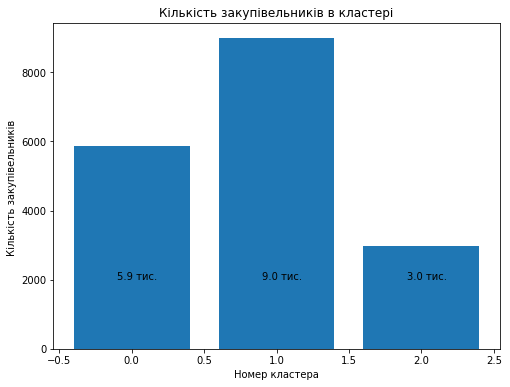

,#_lots,%_lots_reports,$_lots,$_lots_hh,#_cpv,cpv_homo_%,number
cluster_3,,,,,,,
0,123.026939,0.576477,7.731562e+07,0.101527,40.681841,0.121647,5865
1,13.032818,0.731216,3.162957e+06,0.256280,7.316164,0.034552,8989
2,16.274983,0.404841,2.701344e+06,0.291538,9.617371,0.394885,2982


In [83]:
summary_size = pd.DataFrame(df_org.groupby(df_org["cluster_3"]).size())


figure_1=plt.figure(figsize=(8, 6))

# figure 1. Distribution by # of lots
ax_1 = figure_1.add_subplot(111)

plt.bar(summary_size.index, summary_size[0])
for i in range(3):
    ax_1.text(i-0.1, 2000, "{} тис.".format(round(summary_size.loc[i, 0]/1000, 1), 
              fontsize = 16))
plt.title("Кількість закупівельників в кластері")
plt.xlabel("Номер кластера")
plt.ylabel("Кількість закупівельників ")

plt.show()


#summary_3 = df_org[["#_lots", "%_lots_reports", "$_lots", "$_lots_hh", "#_cpv", "cpv_homo_%"]].groupby(df_org["cluster_3"]).agg(["mean", "sum"])
summary_3 = df_org[["#_lots", "%_lots_reports", "$_lots", "$_lots_hh", "#_cpv", "cpv_homo_%"]].groupby(df_org["cluster_3"]).mean()
summary_3["number"] = df_org[["#_lots", "%_lots_reports", "$_lots", "$_lots_hh", "#_cpv", "cpv_homo_%"]].groupby(df_org["cluster_3"]).size()
summary_3

In [331]:
writer = pd.ExcelWriter('summary_clusters.xlsx')
summary_3.to_excel(writer,'Sheet1')
writer.save()

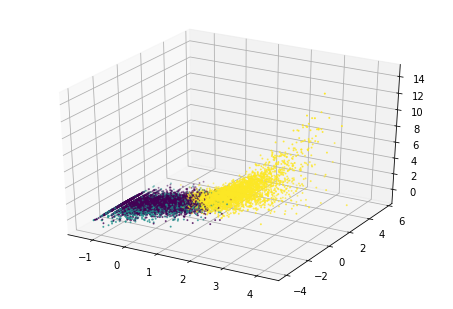

In [317]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(df_org_scaled["#_lots"], df_org_scaled["$_lots"], df_org_scaled["#_cpv"], 
           c=df_org_scaled["cluster_3"],
           s=1)
pyplot.show()

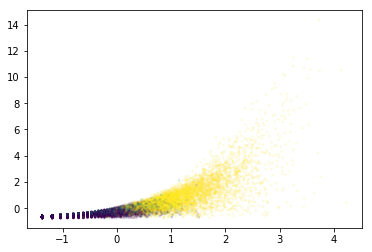

In [319]:
plt.scatter(df_org_scaled["#_lots"], df_org_scaled["#_cpv"], 
            c=df_org_scaled["cluster_3"],
            alpha=0.1,
            s=3)

In [91]:
# from __future__ import print_function

# from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# print(__doc__)


# range_n_clusters = [2, 3, 4, 5, 6]

# for n_clusters in range_n_clusters:

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

In [92]:
# from __future__ import print_function

# from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# print(__doc__)


# range_n_clusters = [2, 3, 4, 5, 6]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)


In [93]:
# plt.scatter(df_org_scaled[:,0], df_org_scaled[:,1], alpha=0.1, s=1)
# plt.show()